# Import libraries

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import warnings
warnings.filterwarnings('ignore')

# Read data

In [21]:
# prompt: read csv data

import pandas as pd

# Replace 'your_file.csv' with the actual path to your CSV file
data = pd.read_csv('/content/signal-data.csv')

# Print the first few rows of the DataFrame to check if it loaded correctly
print(data.head(10).to_string())


                  Time        0        1          2          3       4      5         6       7       8       9      10      11        12   13       14        15       16      17        18       19      20       21       22       23       24      25      26      27       28      29      30      31       32      33       34       35       36       37       38        39     40     41    42        43       44        45        46      47        48   49        50        51   52     53     54      55      56      57      58       59        60       61        62       63       64       65        66      67        68   69        70       71        72        73   74      75      76      77      78      79      80      81      82      83      84  85      86      87         88      89         90      91      92      93      94      95      96   97      98      99     100     101     102     103     104     105     106     107     108  109  110  111     112     113  114       115     116      117 

# Data cleaning

In [34]:
data['Time'] = pd.to_datetime(data['Time'], errors='coerce')

# Step 1: Drop columns with more than 10% missing values
threshold = 0.1 * len(data)  # 10% of the total rows
columns_to_drop = missing_values[missing_values > threshold].index
data_cleaned = data.drop(columns=columns_to_drop)


print("\nTotal missing values before cleaning :", data.isnull().sum().sum())

# Replace null values with 0
data_cleaned = data_cleaned.fillna(data_cleaned.median())

print(data_cleaned.head(10).to_string())

print("\nTotal missing values after cleaning :", data_cleaned.isnull().sum().sum())


Total missing values before cleaning : 41951
                 Time        0        1          2          3       4      5         6       7       8       9      10      11        12   13       14        15       16      17        18       19      20       21       22       23       24      25      26      27       28      29      30      31       32      33       34       35       36       37       38        39     40     41    42        43       44        45        46      47        48   49        50        51   52     53     54      55      56      57      58       59        60       61        62       63       64       65        66      67        68   69        70       71   74      75      76      77      78      79      80      81      82      83      84      86      87         88      89         90      91      92      93      94      95      96   97      98      99     100     101     102     103     104     105     106     107     108     113  114       115     116      117   

# Univariate analysis

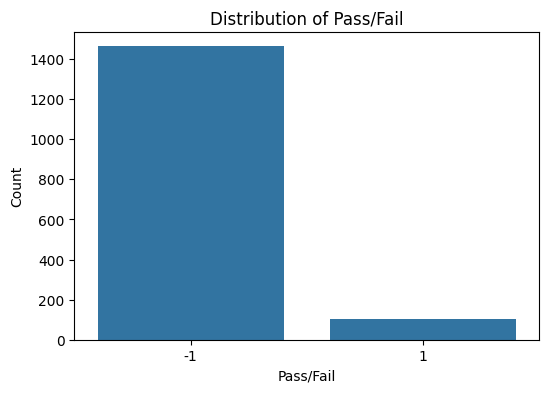

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Univariate analysis: Distribution of the target variable (Pass/Fail)
plt.figure(figsize=(6, 4))
sns.countplot(data=data_cleaned, x='Pass/Fail')
plt.title('Distribution of Pass/Fail')
plt.xlabel('Pass/Fail')
plt.ylabel('Count')
plt.show()

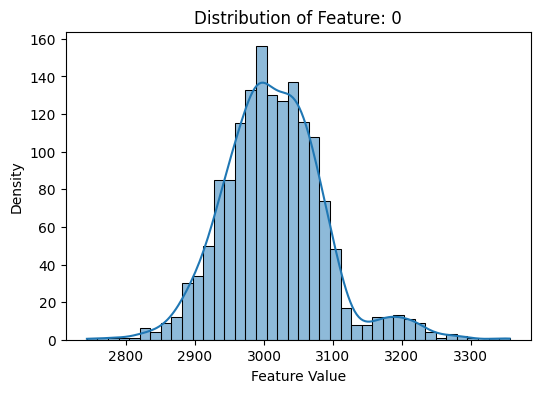

In [48]:
# Univariate analysis of one numerical feature (column 0)
plt.figure(figsize=(6, 4))
sns.histplot(data=data_cleaned, x=data_cleaned.columns[1], kde=True)
plt.title(f'Distribution of Feature: {data_cleaned.columns[1]}')
plt.xlabel('Feature Value')
plt.ylabel('Density')
plt.show()


# Bivariate analysis

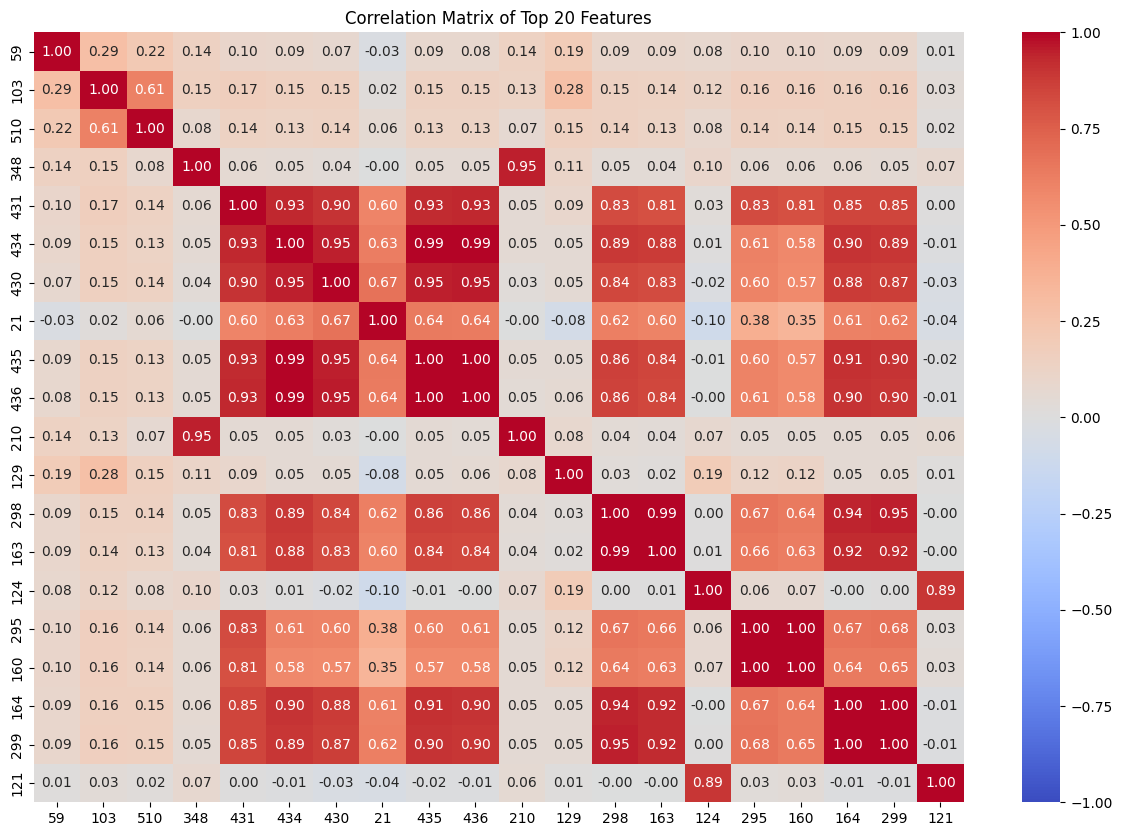

In [50]:
# Bivariate analysis: Correlation between numerical features and Pass/Fail
# Calculating the correlation matrix
correlation_matrix = data_cleaned.corr()

# Correlation of 'Pass/Fail' with other features
corr_with_target = correlation_matrix['Pass/Fail'].sort_values(ascending=False)

# Visualizing a heatmap for the top 20 correlated features with Pass/Fail
top_features = corr_with_target.index[1:21]  # Skip 'Pass/Fail' itself

plt.figure(figsize=(15, 10))
sns.heatmap(data_cleaned[top_features].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1,fmt='.2f')
plt.title('Correlation Matrix of Top 20 Features')
plt.show()


# Data Preprocessing

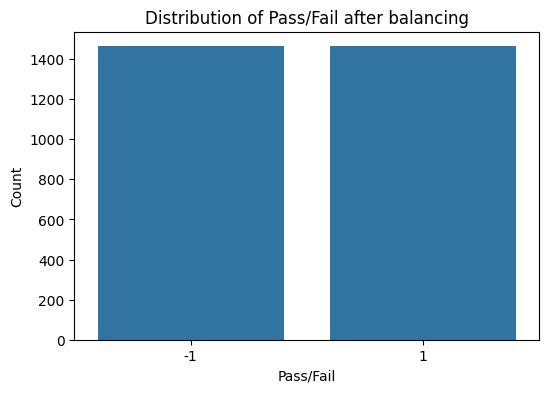

X_train shape: (2340, 20)
y_train shape: (2340,)
X_test shape: (586, 20)
y_test shape: (586,)


In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

# Step 1: Segregating predictors and target
X = data_cleaned.drop(columns=['Pass/Fail', 'Time'])
y = data_cleaned['Pass/Fail']

# Step 2: Balancing the target using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

plt.figure(figsize=(6, 4))
sns.countplot(x=y_resampled)
plt.title('Distribution of Pass/Fail after balancing')
plt.xlabel('Pass/Fail')
plt.ylabel('Count')
plt.show()

# Step 3: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 4: Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Applying PCA for dimensionality reduction (to 20 components)
pca = PCA(n_components=20)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print("X_train shape:", X_train_pca.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test_pca.shape)
print("y_test shape:", y_test.shape)


#Train model - Hyperparameter tuning (GridSearchCV) with 5-fold cross-validation

In [51]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score

# Initialize models
gbc = GradientBoostingClassifier()
knn = KNeighborsClassifier()
log_reg = LogisticRegression(max_iter=500)

# Define hyperparameter grids
param_grid_gbc = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

param_grid_knn = {
    'n_neighbors': [3, 5, 7],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

param_grid_log_reg = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs']
}

# Set up GridSearchCV with 5-fold cross-validation for each model
grid_gbc = GridSearchCV(estimator=gbc, param_grid=param_grid_gbc, cv=5, scoring='accuracy')
grid_knn = GridSearchCV(estimator=knn, param_grid=param_grid_knn, cv=5, scoring='accuracy')
grid_log_reg = GridSearchCV(estimator=log_reg, param_grid=param_grid_log_reg, cv=5, scoring='accuracy')

# Fit the models
grid_gbc.fit(X_train_pca, y_train)
grid_knn.fit(X_train_pca, y_train)
grid_log_reg.fit(X_train_pca, y_train)

# Best parameters and best scores
best_params_gbc = grid_gbc.best_params_
best_score_gbc = grid_gbc.best_score_

best_params_knn = grid_knn.best_params_
best_score_knn = grid_knn.best_score_

best_params_log_reg = grid_log_reg.best_params_
best_score_log_reg = grid_log_reg.best_score_

# Display best parameters and scores
best_params_gbc, best_score_gbc, best_params_knn, best_score_knn, best_params_log_reg, best_score_log_reg


({'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150},
 0.9106837606837607,
 {'n_neighbors': 3, 'p': 2, 'weights': 'uniform'},
 0.8752136752136753,
 {'C': 10, 'solver': 'liblinear'},
 0.6982905982905983)

In [55]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

# Step 1: Use the best estimators to predict on the test set
y_pred_gbc = grid_gbc.best_estimator_.predict(X_test_pca)
y_pred_knn = grid_knn.best_estimator_.predict(X_test_pca)
y_pred_log_reg = grid_log_reg.best_estimator_.predict(X_test_pca)

# Step 2: Evaluate the models

# Gradient Boosting Classifier Evaluation
accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
conf_matrix_gbc = confusion_matrix(y_test, y_pred_gbc)
class_report_gbc = classification_report(y_test, y_pred_gbc)

# KNN Evaluation
accuracy_knn = accuracy_score(y_test, y_pred_knn)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
class_report_knn = classification_report(y_test, y_pred_knn)

# Logistic Regression Evaluation
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
class_report_log_reg = classification_report(y_test, y_pred_log_reg)

# Step 3: Display results for each model
print("Gradient Boosting Classifier:")
print(f"Accuracy: {accuracy_gbc}")
print("Confusion Matrix:\n", conf_matrix_gbc)
print("Classification Report:\n", class_report_gbc)

print("\nK-Nearest Neighbors:")
print(f"Accuracy: {accuracy_knn}")
print("Confusion Matrix:\n", conf_matrix_knn)
print("Classification Report:\n", class_report_knn)

print("\nLogistic Regression:")
print(f"Accuracy: {accuracy_log_reg}")
print("Confusion Matrix:\n", conf_matrix_log_reg)
print("Classification Report:\n", class_report_log_reg)


Gradient Boosting Classifier:
Accuracy: 0.9453924914675768
Confusion Matrix:
 [[279  27]
 [  5 275]]
Classification Report:
               precision    recall  f1-score   support

          -1       0.98      0.91      0.95       306
           1       0.91      0.98      0.95       280

    accuracy                           0.95       586
   macro avg       0.95      0.95      0.95       586
weighted avg       0.95      0.95      0.95       586


K-Nearest Neighbors:
Accuracy: 0.8839590443686007
Confusion Matrix:
 [[239  67]
 [  1 279]]
Classification Report:
               precision    recall  f1-score   support

          -1       1.00      0.78      0.88       306
           1       0.81      1.00      0.89       280

    accuracy                           0.88       586
   macro avg       0.90      0.89      0.88       586
weighted avg       0.91      0.88      0.88       586


Logistic Regression:
Accuracy: 0.7064846416382252
Confusion Matrix:
 [[218  88]
 [ 84 196]]
Classificat

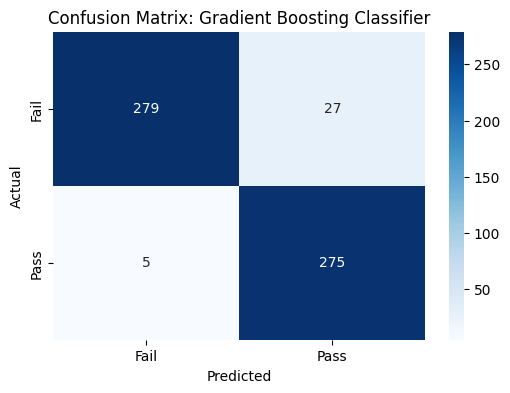

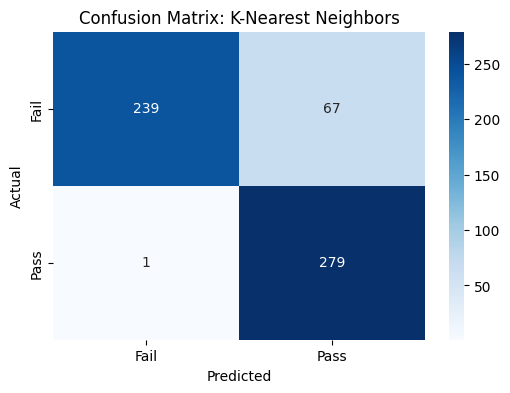

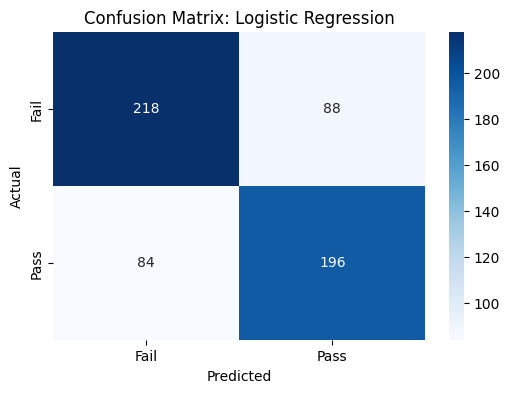

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot confusion matrix
def plot_confusion_matrix(conf_matrix, model_name):
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix: {model_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xticks([0.5, 1.5], ['Fail', 'Pass'])
    plt.yticks([0.5, 1.5], ['Fail', 'Pass'])
    plt.show()

# Plot confusion matrix for each model
plot_confusion_matrix(conf_matrix_gbc, "Gradient Boosting Classifier")
plot_confusion_matrix(conf_matrix_knn, "K-Nearest Neighbors")
plot_confusion_matrix(conf_matrix_log_reg, "Logistic Regression")


# Save the best model

In [56]:
# Step 4: Save the best model (example: Gradient Boosting)
best_model = grid_gbc.best_estimator_
joblib.dump(best_model, 'best_model_gbc.pkl')
print("Best model saved as 'best_model_gbc.pkl'.")

Best model saved as 'best_model_gbc.pkl'.


# Performance metrics

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, f1_score, precision_score, recall_score

# Function to calculate all the performance metrics
def evaluate_model(y_test, y_pred, model_name):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    f1 = f1_score(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Print all metrics
    print(f"--- {model_name} Performance Metrics ---")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"ROC-AUC: {roc_auc}")
    print("\n" + "-"*50 + "\n")

# Step 1: Use the best estimators to predict on the test set
y_pred_gbc = grid_gbc.best_estimator_.predict(X_test_pca)
y_pred_knn = grid_knn.best_estimator_.predict(X_test_pca)
y_pred_log_reg = grid_log_reg.best_estimator_.predict(X_test_pca)

# Step 2: Evaluate the models
evaluate_model(y_test, y_pred_gbc, "Gradient Boosting Classifier")
evaluate_model(y_test, y_pred_knn, "K-Nearest Neighbors")
evaluate_model(y_test, y_pred_log_reg, "Logistic Regression")


--- Gradient Boosting Classifier Performance Metrics ---
Accuracy: 0.9453924914675768
Precision: 0.9105960264900662
Recall: 0.9821428571428571
F1 Score: 0.9450171821305842
ROC-AUC: 0.946953781512605

--------------------------------------------------

--- K-Nearest Neighbors Performance Metrics ---
Accuracy: 0.8839590443686007
Precision: 0.8063583815028902
Recall: 0.9964285714285714
F1 Score: 0.8913738019169329
ROC-AUC: 0.8887371615312791

--------------------------------------------------

--- Logistic Regression Performance Metrics ---
Accuracy: 0.7064846416382252
Precision: 0.6901408450704225
Recall: 0.7
F1 Score: 0.6950354609929078
ROC-AUC: 0.7062091503267973

--------------------------------------------------



# Conclusion report

### Conclusion Report

#### 1. **Gradient Boosting Classifier**:
- **Best Hyperparameters**: `{'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 150}`
- **Accuracy**: 94.54%
- **Performance**:
  - Precision: 91.06%
  - Recall: 98.21%
  - F1-Score: 94.50%
  - ROC-AUC: 94.70%
  - Confusion Matrix: [[279, 27], [5, 275]]
  
The Gradient Boosting Classifier achieved the highest accuracy and balanced performance across all metrics. It effectively classifies both classes with high recall (98% for class 1) and high precision (98% for class -1). It misclassifies only a small number of samples from both classes, making it an excellent model for the task.

#### 2. **K-Nearest Neighbors (KNN)**:
- **Best Hyperparameters**: `{'n_neighbors': 3, 'p': 2, 'weights': 'uniform'}`
- **Accuracy**: 88.40%
- **Performance**:
  - Precision: 80.64%
  - Recall: 99.64%
  - F1-Score: 89.14%
  - ROC-AUC: 88.87%
  - Confusion Matrix: [[239, 67], [1, 279]]
  
The KNN classifier also performed well but had a lower accuracy compared to Gradient Boosting. It exhibited extremely high recall (99.64%), meaning it correctly classified almost all positive instances (class 1), but at the cost of slightly lower precision. This suggests that while the model is very sensitive, it sacrifices some specificity, as indicated by the higher number of false positives.

#### 3. **Logistic Regression**:
- **Best Hyperparameters**: `{'C': 10, 'solver': 'liblinear'}`
- **Accuracy**: 70.65%
- **Performance**:
  - Precision: 69.01%
  - Recall: 70.00%
  - F1-Score: 69.50%
  - ROC-AUC: 70.62%
  - Confusion Matrix: [[218, 88], [84, 196]]
  
Logistic Regression performed the worst among the models, with an accuracy of 70.65%. While its performance in terms of precision, recall, and F1-score is balanced, the values are much lower compared to the other two models. This suggests that logistic regression is not the best choice for this classification task, as it struggles to correctly classify a significant portion of both classes.

---

### **Model Comparison and Final Selection**:
- **Gradient Boosting Classifier** emerges as the best-performing model based on all performance metrics. It provides the highest accuracy, F1-score, and ROC-AUC, along with a well-balanced precision and recall, making it an ideal choice for this classification problem.
- **K-Nearest Neighbors (KNN)** also provides strong results, particularly in recall, but it sacrifices some precision, leading to more false positives. This may still be acceptable in certain use cases where identifying positive instances is critical.
- **Logistic Regression**, while a simple and interpretable model, does not perform well in comparison to Gradient Boosting or KNN, with lower accuracy and a higher rate of misclassifications.

### **Conclusion**:
Based on the performance metrics and overall model comparison, the **Gradient Boosting Classifier** is the recommended model for this task. It provides the best balance between precision, recall, and accuracy, making it suitable for reliable predictions with minimal misclassifications.